In [ ]:
from Binaries import *

In [ ]:
NNExample = NNClassifier("minimal_conv2d_vem_peak_scaled")
TP, FP, TN, FN = NNExample.load_and_print_performance("validation_data", usecols = [(2, 3, 4), 0, 0, (2, 3, 4)])

In [ ]:
def spd_energy_efficiency(self, TP, FP, TN, FN, **kwargs) -> None : 

            warnings.simplefilter("ignore", RuntimeWarning)
            draw_plot = not kwargs.get("quiet", False)

            # Prediction structure: [ integral, n_signal, energy, SPD, Theta]
            ldf_params = np.loadtxt("/cr/tempdata01/filip/QGSJET-II/LDF/fitparams.csv", usecols = [4,5])
            colormap = cmap.get_cmap("plasma")

            theta_bins = [26, 38, 49, 60]
            energy_bins = [10**16.5, 1e17, 10**17.5, 1e18, 10**18.5, 1e19]
            miss_sorted = [[ [] for t in range(len(theta_bins) + 1) ] for e in range(len(energy_bins) + 1)]
            hits_sorted = [[ [] for t in range(len(theta_bins) + 1) ] for e in range(len(energy_bins) + 1)]
            e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]
            fit_params = [[] for e in range(len(energy_bins) + 1)]
            fit_uncertainties = [[] for e in range(len(energy_bins) + 1)]

            # sort predictions into bins of theta and energy
            for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

                E, SPD, T = source[:, 0], source[:, 1], source[:, 2]

                # sort misses / hits w.r.t zenith and primary energy
                theta_indices = np.digitize(T, theta_bins)
                energy_indices = np.digitize(E, energy_bins)
                
                for e, t, spd in zip(energy_indices, theta_indices, SPD):
                    target[e][t].append(spd)

            for e, (hits_by_energy, misses_by_energy) in enumerate(zip(hits_sorted, miss_sorted)):

                if draw_plot:
                    fig = plt.figure()
                    plt.xlim(0, 3000)
                    plt.ylim(-0.05, 1.05)
                    plt.plot([], [], ls = ":", c = "k", label = "Simulated")
                    plt.plot([], [], ls = "solid", c = "k", label = "Extrapolation")
                    plt.legend(loc = "upper right", title = e_labels[e] + r" $\leq$ log($E$ / eV) < " + e_labels[e + 1], title_fontsize = 19)

                for t, (hits_by_theta, miss_by_theta) in enumerate(zip(hits_by_energy, misses_by_energy)):

                    # spd_bins = np.linspace(min(min(hits_by_theta), min(miss_by_theta)),
                    #                        max(max(hits_by_theta), max(miss_by_theta)), 20)

                    p50, scale = ldf_params[e * 5 + t]
                    ldf = lambda x : station_hit_probability(x, 1, p50, scale)

                    spd_bins = list(np.geomspace(1, 1500, kwargs.get("n_bins", 30)))
                    spd_bins += list(np.arange(1500 + np.diff(spd_bins)[-1], 3000, np.diff(spd_bins)[-1]))
                    # spd_bins = np.linspace(0, 3000, 20)
                    c = colormap(t / len(hits_by_energy))

                    x_hist, sig = np.histogram(hits_by_theta, bins = spd_bins)
                    o_hist, sig = np.histogram(miss_by_theta, bins = spd_bins)
                    x_val, y_val, y_err = [], [], []


                    # draw individual patches
                    for i, (x, o) in enumerate(zip(x_hist, o_hist)):


                        if x == o == 0: continue

                        # determine x
                        left_edge_x, right_edge_x = sig[i], sig[i + 1]
                        center_x = 0.5 * (left_edge_x + right_edge_x)
                        x_val.append(center_x)
                        
                        # print(center_x, x, o)

                        # determine y
                        center_y = x / (x + o)
                        height = 1/(x+o)**2 * np.sqrt(x * o**2 + o * x**2 + 2 * x*o)
                        ldf_left, ldf_right, ldf_center = ldf(left_edge_x), ldf(right_edge_x), ldf(center_x)
                        top_left_y, bottom_left_y = (center_y + height) * ldf_left, (center_y - height) * ldf_left
                        top_right_y, bottom_right_y = (center_y + height) * ldf_right, (center_y - height) * ldf_right
                        center_y *= ldf_center
                        y_val.append(center_y)
                        y_err.append(height / 2)

                        coordinates = [[left_edge_x, top_left_y], [right_edge_x, top_right_y], [right_edge_x, bottom_right_y], [left_edge_x, bottom_left_y]]

                        draw_plot and plt.gca().add_patch(Polygon(coordinates, closed = True, color = c, alpha = 0.1, lw = 0))

                    draw_plot and plt.errorbar(x_val, y_val, color = c, marker = "s", markersize = 5, ls = ":")

                    # # perform efficiency fit
                    # try:
                    #     popt, pcov = curve_fit(station_hit_probability, x_val, y_val, 
                    #                                           p0 = [y_val[0], p50, scale],
                    #                                           bounds = ([0, 0, 0], [1, np.inf, np.inf]),
                    #                                           sigma = y_err,
                    #                                           absolute_sigma = True)
                    # except ValueError:
                    #     popt, pcov = curve_fit(station_hit_probability, x_val, y_val, 
                    #                                           p0 = [y_val[0], p50, scale],
                    #                                           bounds = ([0, 0, 0], [1, np.inf, np.inf]),
                    #                                           maxfev = 10000)


                    # fit_params[e].append(popt)
                    # fit_uncertainties[e].append(pcov)

                    # if draw_plot:
                    #     X = np.linspace(0, 3000, 100)
                    #     plt.plot(X, station_hit_probability(X, 1, p50, scale), c = c, lw = 2)

                if draw_plot:
                    plt.xlabel("Shower plane distance / m")
                    plt.ylabel("Trigger efficiency")

                    norm = BoundaryNorm([0] + theta_bins + [90], colormap.N)
                    ax2 = fig.add_axes([0.95, 0.1, 0.01, 0.8])
                    ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"Zenith angle")

                # raise StopIteration

            # if isinstance(self, NNClassifier): save_dir = f"/cr/data01/filip/models/{self.name}/model_{self.epochs}/ROC_curve/{dataset}/fit_params.csv"
            # elif isinstance(self, HardwareClassifier): save_dir = f"/cr/data01/filip/models/{self.name}/ROC_curve/{dataset}/fit_params.csv"

            # with open(save_dir, "w") as file:
            #     for energy in fit_params:
            #         np.savetxt(file, energy)

            warnings.simplefilter("default", RuntimeWarning)

            # return np.array(fit_params), np.array(fit_uncertainties)

In [ ]:
spd_energy_efficiency(NNExample, TP, FP, TN, FN)

In [ ]:
Hardware = HardwareClassifier()

TP, FP, TN, FN = Hardware.load_and_print_performance("fullscale_downsampled_vem_peak_scaled", usecols = [(2, 3, 4), 0, 0, (2, 3, 4)])
spd_energy_efficiency(Hardware, TP, FP, TN, FN)

In [ ]:
test_hits = np.loadtxt("/cr/data01/filip/models/HardwareClassifier/ROC_curve/fullscale_downsampled_vem_peak_scaled/true_positives.csv", usecols = [3])
test_misses = np.loadtxt("/cr/data01/filip/models/HardwareClassifier/ROC_curve/fullscale_downsampled_vem_peak_scaled/false_negatives.csv", usecols = [3])

In [ ]:
bin_hits, bins, _ = plt.hist(test_hits, histtype = "step", bins = 300)
bin_misses, bins, _ = plt.hist(test_misses, histtype = "step", bins = 300)
plt.axvline(100)

In [ ]:
plt.plot(0.5 * (bins[1:] + bins[:-1]), bin_hits / (bin_hits + bin_misses))

In [1]:
from Binaries import *

_, ExampleData = EventGenerator("all", real_background = True)

def plot(trace):

    plt.plot(range(len(trace[0])), trace[0])
    plt.plot(range(len(trace[1])), trace[1])
    plt.plot(range(len(trace[2])), trace[2])


[INFO] -- LOADING RANDOMS: randoms0313.csv                    
[INFO] -- LOADING RANDOMS: randoms0322.csv                    


In [2]:
ExampleData.__reset__()

spdistance_hist = []
integral_hist = []
color_hist = []
bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]
weird_traces = []

for batch, (traces, labels, metadata_per_batch) in enumerate(ExampleData):

    for trace, label, metadata in zip(traces, labels, metadata_per_batch):

        if not np.argmax(label): continue

        if metadata[1][2] < 100 and metadata[1][1] > 10**18:
            weird_traces.append(trace)

        integral_hist.append(metadata[0])
        spdistance_hist.append(metadata[1][2])
        color_hist.append(np.digitize(metadata[1][1], bins))

[INFO] -- LOADING RANDOMS: randoms0729.csv                    
[INFO] -- LOADING RANDOMS: randoms0794.csv                    


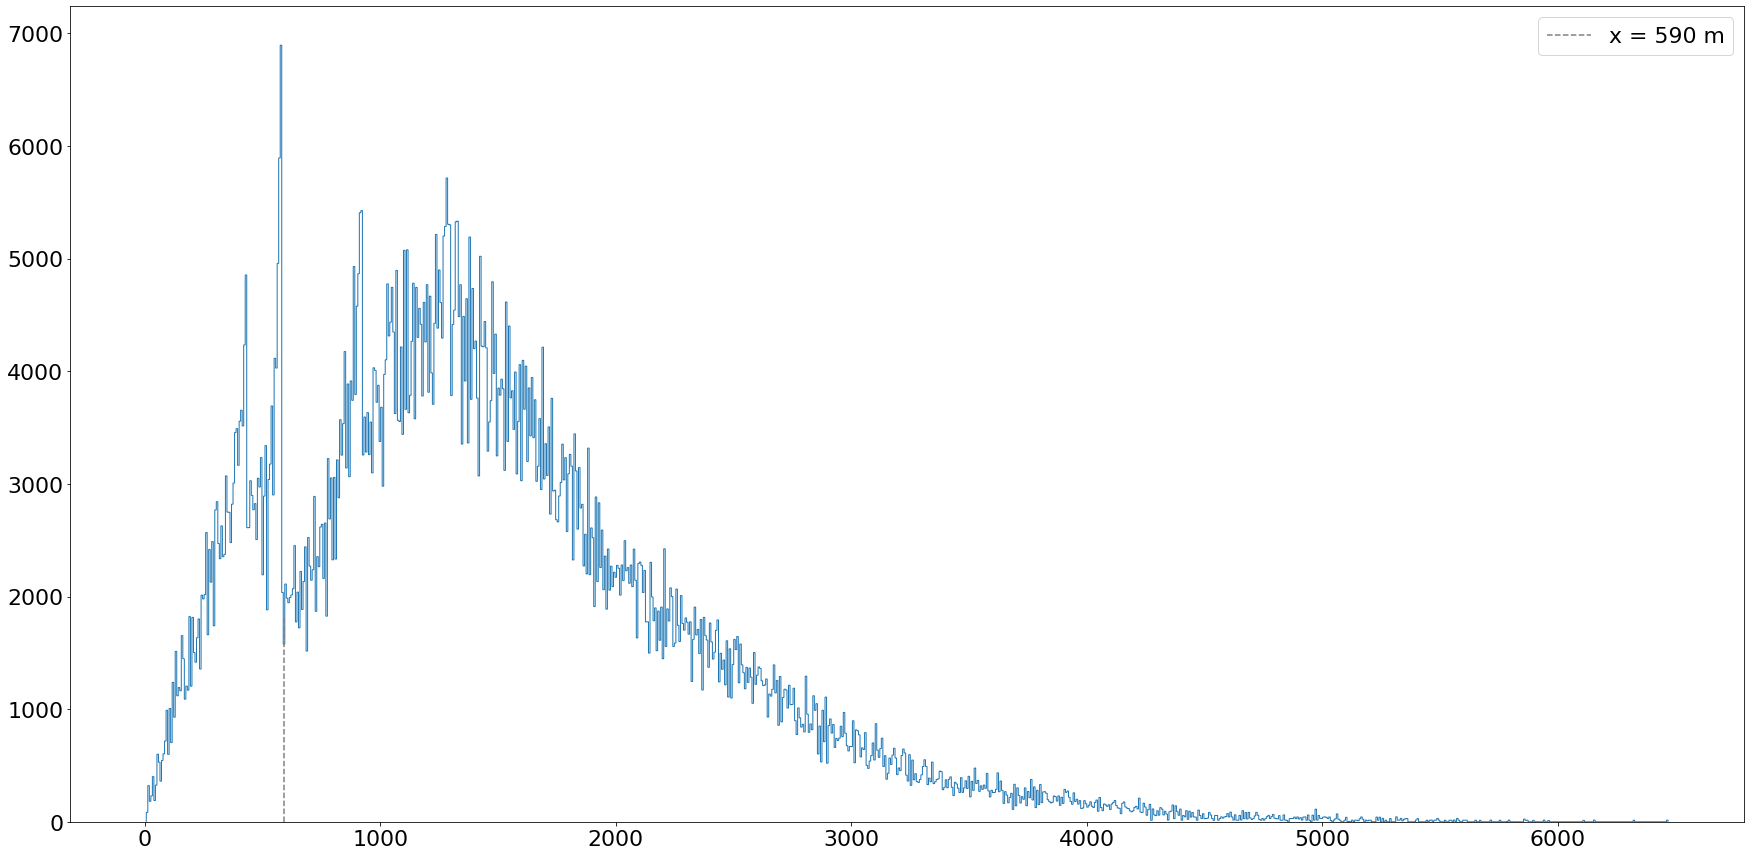

In [3]:
_, _, _ = plt.hist(spdistance_hist, bins = 1000, histtype = "step")
plt.axvline(590, ymax = 0.25, c = "grey", ls = "--", label = "x = 590 m")

plt.legend()

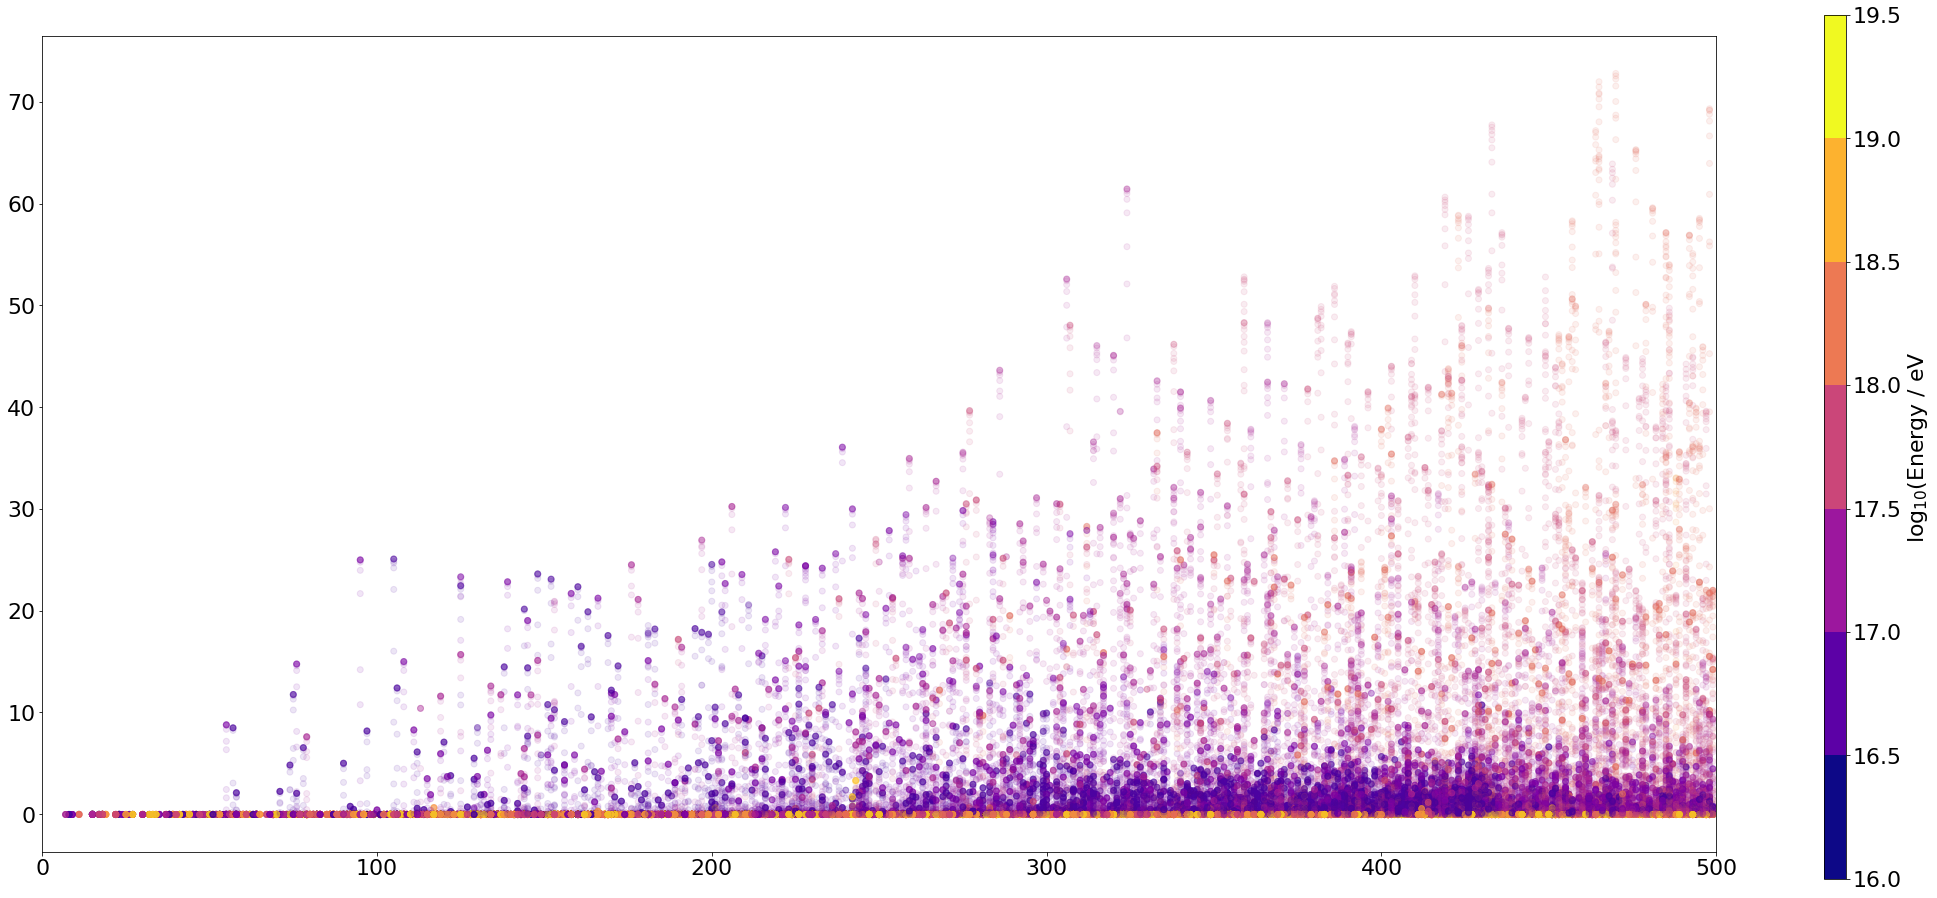

In [4]:
spdistance_hist = np.array(spdistance_hist)
integral_hist = np.array(integral_hist)
color_hist = np.array(color_hist)
x_upper_limit = 500
colormap = cmap.get_cmap("plasma")

fig = plt.figure()

plt.scatter(spdistance_hist[spdistance_hist < x_upper_limit], integral_hist[spdistance_hist < x_upper_limit], alpha = 0.1, c = colormap(np.array(color_hist[spdistance_hist < x_upper_limit]) / len(bins)))
plt.xlim(0, x_upper_limit)

norm = BoundaryNorm(np.log10(bins), colormap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.01, 0.8])
ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"log$_{10}$(Energy / eV")

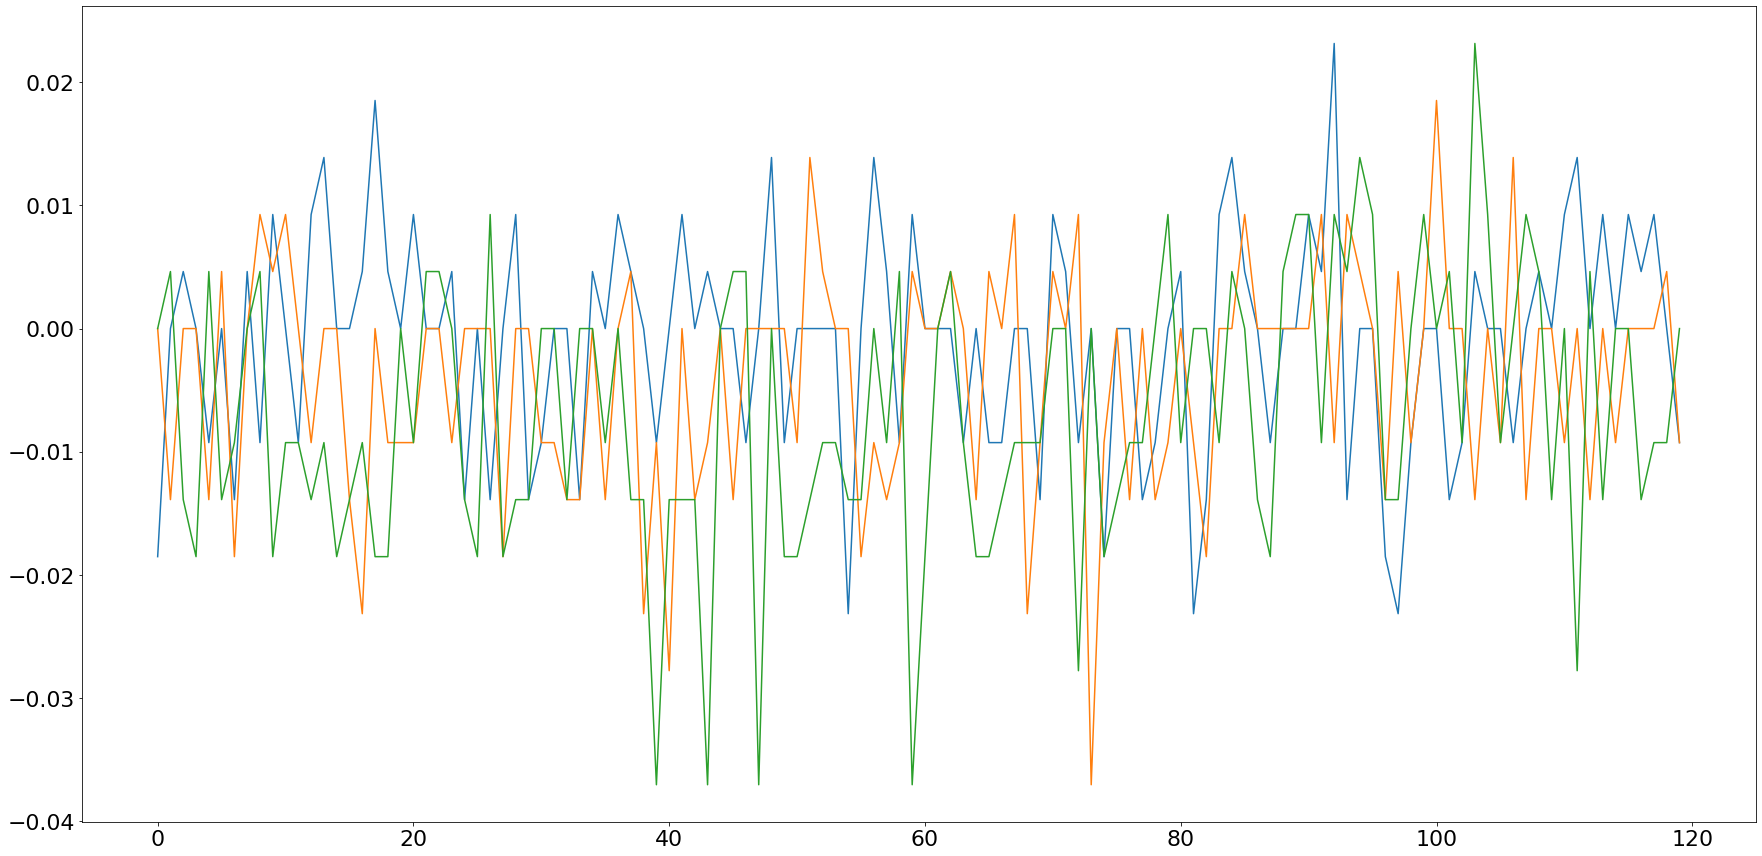

In [6]:
plot(weird_traces[0])